## Soil Sensor deployment at farm scale: a feasibility analysis
_Q: Can such consumer technology be used for remote sensing at farm scale? With positive ROI?_

![img source](https://i.imgur.com/bknlfCOh.jpg)

### Focus: Research question(s) and scope
Per the __context__ defined in the [README document](README.md), the focus of this first test is to understand (with minimal investment of time) the given technology, essentially:

1. the Flower Power Soil sensor;
2. the Flower Power app for iPhone;
3. the data files that flow from iPhone app to cloud, and back to user desktop via Python script developed & maintained by GROW Observatory; and
4. the GROW observatory hub website, as a source of end-user information and support.

![img source](https://i.imgur.com/RdGdMxEh.jpg)
![img source](https://i.imgur.com/BPCkrhuh.jpg)

Given that: 

- The Flower Power sensor and app (see images above, as deployed in the first equipement check) work together essentially as advertised, though there are some doubts about hardware and software robustness and support [1]; 
- The [GROW Observatory website](https://hub.growobservatory.org/my-data/sensors/) (NB: login required) gives a somewhat useful but limited view of sensor data (see image just below[2]) and [discussion forums](https://hub.growobservatory.org/discussions) that have yet to shape-up into a very useful source of collegial exchange/ support.

![img source](https://i.imgur.com/l2XOgOGh.png)

Moreover: Full deployment of 320 sensors in the manner prescribed by GROW (in [end-user documentation](GROW-Training-Manual.pdf)), including maintenance of devices in the field (assuming some non-zero failure rate, and battery change every 6 months) along with periodic (biweekly is prescribed) data acquisition and uploading for the (3 years) duration of project will require a significant investment on part of this GROW site.

So: Our focus at this point is on the data files -now holding raw data uploaded from all our sensors, downloadable on demand as a set of .csv files (one per sensor) - and figuring out how the information held in these files can be leveraged to add value to our farm operations.

**Preliminary Questions**: A few assumptions that must be validated before we can do anything useful with this data, i.e.:
- DataFlow: Can we in fact download the data easily enough, in a form that we can work with using Pandas? (a Python library: as Python is the language of data tranfer script, we choose that over R, although that is also a good choice for data munging/ analysis);
- Data Model: What indicators are available for tracking? Using what units of measure? Can records be correlated, as time-series data, with data from other sources (e.g. local weather)?
- Data Latency:  From time of upload, how quickly is data available for download?  And what if any is the maxium latency between time-stamp of last record, and time of data upload?
- Data Integrity: Is the data complete (since sensor boot-up time, with no null values) and accurate (does it appear to make sense, as compared with what's known about local conditions)?

SCOPE: For the purposes of this preliminary analysis, data from one sensor (deployed on August 20 in the rain-fed uncultivated zone near top of the farm) will be sufficient.  Data from several additional sensors that have since been implanted will be included in subsequent analysis (test2), once the questions above have been answered.

### Data Import & Hygiene
Having downloaded the data (easily enough, using the python script supplied by GROW observatory tech support), the first step is to import our data -along with any tools needed to process it- and run a few basic checks:

In [29]:
import pandas as pd   #load the analytics software library
df=pd.read_csv("./sensor_data_2/Flower power 64E8.csv")   # Import the .csv datafile from the "test1" sensor
print("Pandas version ",pd.__version__)  # confirm software version, to help ensure reproducibility of results
print("Number of Rows, Columns = ",df.shape)  #to know the depth & scope of dataframe
print("Column Headers: ",df.columns)  # to see names of column headers
print("Datatype of index = ",type(df.index[0]))  # to confirm datatype of the index

Pandas version  0.23.4
Number of Rows, Columns =  (6723, 7)
Column Headers:  Index(['NickName', 'serial_number', 'capture_datetime_utc', 'fertilizer_level',
       'light', 'soil_moisture_percent', 'air_temperature_celsius'],
      dtype='object')
Datatype of index =  <class 'int'>


**At first glance:** Considering 6723 records (which pandas ingested without a burp) from a single sensor over <10 weeks... This indicates a pretty hi-frequency sampling interval.
Moreover: If datetime is taken as the 1st column, with an index column of type integer outside that frame, this means that pandas is using its own assigned sequential as the index... But that does not support our purposes so well.
What we want is to treat this as time-series data, so that we can corelate data from different sources (i.e. sensors [2] -but also local weather data, and perhaps weather & sensor data from other GROW sites) along the axis of time.
So: we will create a script to take the datetime field as our index, first converting it to the "Timestamp" datatype, which lets us leverage some powewrful methods that pandas ascribes to this datatype.

In [30]:
# re-Import the .csv datafile from the "test1" sensor, 
# convert the "capture_datetime_utc" column to parse those strings into useful datetime format
# change index to be that column (versus the assigned ID that is pandas default)

df=pd.read_csv("./sensor_data_2/Flower power 64E8.csv",parse_dates=["capture_datetime_utc"], index_col="capture_datetime_utc")

# now ask pandas again to confirm details specified above, i.e.:
print("Number of Rows, Columns = ",df.shape)  #to know the depth & scope of dataframe
print("Column Headers: ",df.columns)  # to see names of column headers
print("Datatype of index = ",type(df.index[0]))  # to confirm datatype of the index
print("Check dataframe for null values: ",df.isnull().values.any())

Number of Rows, Columns =  (6723, 6)
Column Headers:  Index(['NickName', 'serial_number', 'fertilizer_level', 'light',
       'soil_moisture_percent', 'air_temperature_celsius'],
      dtype='object')
Datatype of index =  <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Check dataframe for null values:  False


**CHECK:** As proved by these 4 reports, Pandas has fixed the dataframe as requested, and it is complete (i.e. devoid of null values).  So we can proceed to explore the data in more depth.

### Exploring the Data

As usual for a dataframe of any size too large for human comprehension, we'll do three things:
- inspect the first few records
- inspect the last few records
- run the "describe" method, which provides a few key Descriptive Statistics

In [31]:
df.head()   #or df.iloc[0:5] , gives first 5 records in either case

,NickName,serial_number,fertilizer_level,light,soil_moisture_percent,air_temperature_celsius
capture_datetime_utc,,,,,,
2018-08-17 11:00:34,Flower power 64E8,PI040298AD5I206193,-1.0,120.32,13.87,44.22
2018-08-17 11:15:34,Flower power 64E8,PI040298AD5I206193,-1.0,125.49,14.26,45.12
2018-08-17 11:30:34,Flower power 64E8,PI040298AD5I206193,-1.0,129.65,14.13,44.69
2018-08-17 11:45:34,Flower power 64E8,PI040298AD5I206193,-1.0,134.09,14.00,46.63
2018-08-17 12:00:34,Flower power 64E8,PI040298AD5I206193,-1.0,138.83,14.00,46.63


In [32]:
df.tail()  #last 5 records, to confirm timestamp of last update and continuity of update intervals

,NickName,serial_number,fertilizer_level,light,soil_moisture_percent,air_temperature_celsius
capture_datetime_utc,,,,,,
2018-10-26 10:26:26,Flower power 64E8,PI040298AD5I206193,0.54,8.11,26.15,22.58
2018-10-26 10:41:26,Flower power 64E8,PI040298AD5I206193,0.54,32.19,26.51,26.19
2018-10-26 10:56:26,Flower power 64E8,PI040298AD5I206193,0.54,30.73,26.27,27.53
2018-10-26 11:11:26,Flower power 64E8,PI040298AD5I206193,0.54,45.25,26.51,29.26
2018-10-26 11:26:26,Flower power 64E8,PI040298AD5I206193,0.54,46.58,26.28,35.27


In [33]:
df.describe()  #gives a summary of descriptive statistics for the dataframe across all columns

,fertilizer_level,light,soil_moisture_percent,air_temperature_celsius
count,6723.000000,6723.000000,6723.000000,6723.000000
mean,-0.754727,30.918902,16.396573,27.970001
std,0.570750,46.058009,5.743328,11.493330
min,-1.000000,0.100000,13.230000,9.660000
25%,-1.000000,0.100000,13.740000,19.230000
50%,-1.000000,0.700000,14.000000,23.330000
75%,-1.000000,49.060000,14.380000,37.685000
max,0.640000,173.350000,39.900000,55.000000


**Evaluation:** Let us consider what this tells us about the data:
- **Data model:** These 4 metrics are indeed what we are interested to monitor. As to the units: degrees celsius for air temperature is perfectly comprehensible, and soil moisture as a percentage makes sense... But the light column does not specify units, though it is labelled as both "live lux" and "average klux" on the Flower Power app.  As for fertilizer level: this one is a mystery, as no hint is given anywhere in the software as to units of measure or how values are calculated.
- **Time dimension:**  The data appears to have been logged at precise 15 minute intervals, using UTC (Co-Ordinated Universal Time) values -that is one hour behind our local time in Portugal (easily converted by pandas on-the-fly, if we specify our locality).  As to latency: there appears to be no appreciable delay between the time when data is uploaded and when it becomes available for download, but then the timestamp of last record is a few hours old.  Also: some hours will elapse before it shows up on the GROW observatory website.
- **Data integrity/ accuracy:** In the absence of any reference values[3], about all we can do is a common-sense reasonability check.  Considering: 
    - _*Temperature:*_ Average (i.e. mean) temperature seems reasonable for the last month, as does the minimum value.  The maximum value is surprising;  hard to imagine how temperature around this sensor could have reached 55 degrees, even on the hottest day.  But considering the values at 25/50/75 percentile rank, and the standard deviation, it seems the values follow a reasonably normal distribution, so that max value looks like an anomaly we should perhaps examine more closely.
    - _*Soil Moisture:*_ The percentages seems to fall within a reasonable range, considering that there was significant rainfall toward the end of the period; this being probably the most critical indicator for our purposes, we'll dig into this one more deeply in a moment.
    - _*Light:*_ I don't know enough about light measurement to say if these values are reasonable, but what i can say is that the meter value drops in real-time as my shadow falls over the sensor, and the graph displays peaks and valleys every day and night (respectively), as you would expect (also true for the Temperature reading, NB).
    - _*Fertilizer Level:*_ Don't know what to make of this one... But it is not so critical for immediate purposes.

So: Soil Moisture being the metric that we're most concerned to monitor, let's look at those values in a comprehensible form -i.e. daily average, probably good enough.

In [34]:
#average moisture reading as of the last full day (NB: July 18 was partial, as data was downloaded that afternoon.)
print("last full day's average soil moisture % = ",df["2018-10-26"].soil_moisture_percent.mean())
print ("")
#daily average moisture readings since sensor bootup
print ("daily average soil moisture % for the last month = (date | value) : ")
df.soil_moisture_percent.resample('D').mean()

last full day's average soil moisture % =  26.42717391304348

daily average soil moisture % for the last month = (date | value) : 


capture_datetime_utc
2018-08-17    14.335000
2018-08-18    14.174167
2018-08-19    14.162188
2018-08-20    14.138229
2018-08-21    14.103125
2018-08-22    14.112708
2018-08-23    14.078144
2018-08-24    14.005729
2018-08-25    14.008229
2018-08-26    13.957292
2018-08-27    13.919062
2018-08-28    13.942708
2018-08-29    13.909271
2018-08-30    13.929375
2018-08-31    13.964375
2018-09-01    13.941875
2018-09-02    13.896562
2018-09-03    13.956458
2018-09-04    13.889375
2018-09-05    13.957292
2018-09-06    13.969896
2018-09-07    13.922917
2018-09-08    13.984271
2018-09-09    13.956563
2018-09-10    14.008542
2018-09-11    13.964479
2018-09-12    13.973333
2018-09-13    13.952500
2018-09-14    13.883229
2018-09-15    13.930521
                ...    
2018-09-27    13.896250
2018-09-28    13.891146
2018-09-29    13.851875
2018-09-30    13.901458
2018-10-01    13.886979
2018-10-02    13.859896
2018-10-03    13.833958
2018-10-04    13.838854
2018-10-05    13.821354
2018-10-06    13.83

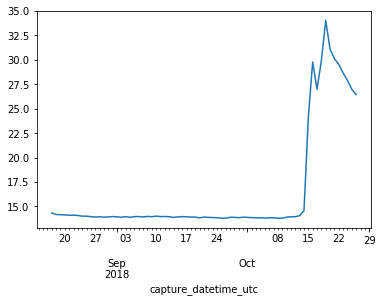

In [35]:
%matplotlib inline
df.soil_moisture_percent.resample('D').mean().plot(kind='line')
# a graphical plot of those daily average moisture values

These values seem reasonable (although dangerously low for much of the period, according to the Flower Power app [4]), and do reflect some quite significant changes, which is reasonable, considering those few days with significant rainfall toward the end of the period.

For more insight, let's pull a graph of the fully granular (i.e. 15 minute interval) data.

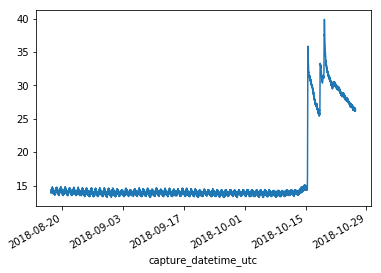

In [36]:
%matplotlib inline
df.soil_moisture_percent.plot(kind='line')
# a plot of that moisture history with full granularity (i.e. 15-min intervals)

Interesting!  Note how daily avg SM value is kicking around between low 13.x and high 14.x from boot-up on Aug 17 until Oct 15, when it spikes to high 30's, drops very rapidly, spikes again to near 40, but then tails off at a slower rate... Still in the high 20's, which value i expect it will retain as a minimum until the rainy season is past.

### CONCLUSIONS: notes and questions for further study

#### Notes:
[1] There is some doubt about impermeability of the battery compartment, per [Amazon product reviews](https://www.amazon.com/gp/customer-reviews/R3LHX6X69XHFR/ref=cm_cr_dp_d_rvw_ttl?ie=UTF8&ASIN=B00FOM2Y6W), along with other issues (esp. problems after firmware update) [discussed in the online user support forums](https://community.parrot.com/t5/Flower-Power/Flower-Power-fails-to-read-mositure-after-update-to-v2-02/m-p/149164) hosted by Parrot company -OEM of the Flower Power hardware and software, who has [officially abandoned support of the product](https://community.parrot.com/t5/Flower-Power/End-of-support-Removing-Parrot-Flower-Power-from-IFTTT/m-p/165883).  Though GROW Observatory appears to have assumed responsibility for support, it is unclear at this point if this extends to the mobile app and/or the sensor hardware and firmware.

[2] Regarding the [sensor visualization page](https://hub.growobservatory.org/my-data/sensors/) and its current limitations, there is now [a forum thread describing the issues](https://hub.growobservatory.org/discussion/sensor-data-visualization-page), along with response from GROW Observatory support team indicating that they are aware of the issues (still open as of this writing) and are working to solve them.

[3] We are getting data from each sensor as its own .csv file... Which means that data from these files must be joined, in order to analyse conditions across sensors (and different GROW sites, potentially) along the axis of time.  CAUTION:  this could be an expensive join!  We may want to concatenate these files, for the purposes of such analysis. 

[4] The Flower Power app contains a database of some >6k plants, whose needs are taken into account in giving to the user information about whether plant is getting too little or too much water/ fertilizer/ light/ temperature (could be very handy for JIT -i.e. precision agriculture- interventions).  This feature does not appear to be reflected in the "My Sensors" page at GROWobservatory.org.

#### Remaining Questions:

1. Sensor Fidelity: to confirm accuracy of readings, can we replicate results across two sensors placed in essentially identical conditions, with sensor boot-up at essentially the same time?
2. Timing: to collect and upload data from a single sensor, proceding with minimal delay to the next, repeat ad (n)finitum: how much time per sensor-visit is required? to what extent can we minimze latency between these operations? and
3. How can we correlate data along the time dimension? rounding off to the nearest common interval?

#### Next Steps:
Considering the importance of these questions, as they relate to the farm's primary motivation in this project (i.e. using the gathered data to inform better farm management decisions), it seems prudent to get them answered -again, with minimal investment of resources- before scaling up to full deployment.  So we will proceed to conduct a second test, using several more sensors placed for ease of deployment/ monitoring on the farm -documentation of same to be posted at [the github repository](https://github.com/ludwa6/Analysing-SSM) that host's this project's documentation.